## Analysis on Loan Customer

Objective dari notebook ini adalah untuk mengetahui bagaimana sebuah perusahaan loan memilih customer mana yang cocok untuk diterima peminjamannya. Dan juga untuk menentukan features apa saja yang berpengaruh pada algoritma mesin learning.

## Introduction

Nama saya Andrian Tanjung, saya mempunyai background di non-IT namun saya tertarik dengan analisa dimana menemukan sebuah pola seperti permainan yang menyenangkan. 

## External Link

https://public.tableau.com/app/profile/andrian5182/viz/Talent_16860269292150/Dashboard1?publish=yes
Mohon maaf sebelumnya dashboard yang saya buat tidak dapat menunjukan radar chart. Saya sudah melihat dari berbagai sumber namun sangat limited baik di youtube maupun bacaan lainnya, tetap tidak mengerti bagaimana cara melakukannya sehingga saya mengisi dengan apa yang saya bisa presentasikan dalam waktu yang ada ini.

## Working Area

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


### Data Loading and Overview

Disini kita akan melihat data types dan statistik deskriptif dari data

##### Data Types

In [3]:
missing_values = ["n/a","na","--","nan","no","?"]                   ## list missing values
df = pd.read_csv('lion-loan-train.csv', na_values=missing_values)   ## CSV read
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df[df.isnull().any(axis=1)]     ## showing the missing values

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
16,LP001034,Male,No,1,Not Graduate,No,3596,0.0,100.0,240.0,NaN,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,LP002933,NaN,No,3+,Graduate,Yes,9357,0.0,292.0,360.0,1.0,Semiurban,Y
597,LP002943,Male,No,NaN,Graduate,No,2987,0.0,88.0,360.0,0.0,Semiurban,N
600,LP002949,Female,No,3+,Graduate,NaN,416,41667.0,350.0,180.0,NaN,Urban,N
601,LP002950,Male,Yes,0,Not Graduate,NaN,2894,2792.0,155.0,360.0,1.0,Rural,Y


- Diketahui data mempunyai 614 entries dan 13 fitur dengan 4 numerikal tipe data dan sisanya adalah berupa categorical yang perlu kita ubah nanti.
- Terdapat missing value di beberapa kolom dengan jumlah yang tidak lebih dari 10% pada setiap featurenya, dan tidak terdapat suatu pola pada missing value tersebut yang dimana dapat kita kategorikan dalam MCAR (missing completely at random). Namun jika semua di jumlah menjadikan 134 entries data yang dimana lebih dari 20% total data. Selain hal itu juga karena jumlah data yang tidak terlalu banyak, dan merupakan hal finansial yang cukup sensitive maka imputasi merupakan cara terbaik untuk menangani missing value tersebut.Agar mendapatkan hasil imputasi yang baik maka akan dilakukan machine learning imputation (KNN imputer technique) untuk numerical dan simple imputer untuk categorical
- Tidak terdapat duplikat data

##### Statistic Descriptive

In [8]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
df.describe(include='object')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [10]:
cat_col = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
num_col = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
## numeric and categorical columns

## categorical overview
for i in cat_col:
    print(df[i].value_counts())
    print('-' * 10)

Gender
Male      489
Female    112
Name: count, dtype: int64
----------
Married
Yes    398
No     213
Name: count, dtype: int64
----------
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
----------
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
----------
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
----------
Credit_History
1.0    475
0.0     89
Name: count, dtype: int64
----------
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64
----------


- Dari numerikal statistik dapat kita lihat bahwa terdapat outliers dari nilai median dan rata-rata yang cukup berjauhan (selain 'Credit_History)
- Dari categorical statistik tidak terlihat ada feature yang memiliki high cardinality
- Karena tidak adanya modeling maka categorical engineering akan dilakukan secara manual

### Data Cleaning

In [11]:
df.drop(columns='Loan_ID', inplace=True)    ## dropping the ID column

In [12]:
## numerical variables
KNNimputer = KNNImputer(n_neighbors=5)        ## calling the KNN Imputer
miss_col_num = ['LoanAmount','Loan_Amount_Term']
df_imp1 = df[miss_col_num]                       ## variable for the features
imputed = KNNimputer.fit_transform(df_imp1)    ## fit transform into the dataframe
df[miss_col_num] = imputed

## categorical variables
simpleimputer = SimpleImputer(strategy='most_frequent')
miss_col_cat = ['Gender','Married','Dependents','Self_Employed','Credit_History']
df_imp2 = df[miss_col_cat]
imputed = simpleimputer.fit_transform(df_imp2)
df[miss_col_cat] = imputed

In [13]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Sekarang sudah tidak terdapat missing value dan kita dapat melanjutkan analisa kita.

### Exploratory Data

Kita akan melihat visualisasi setiap categorical dan numerik terhadap 'Loan_Status'

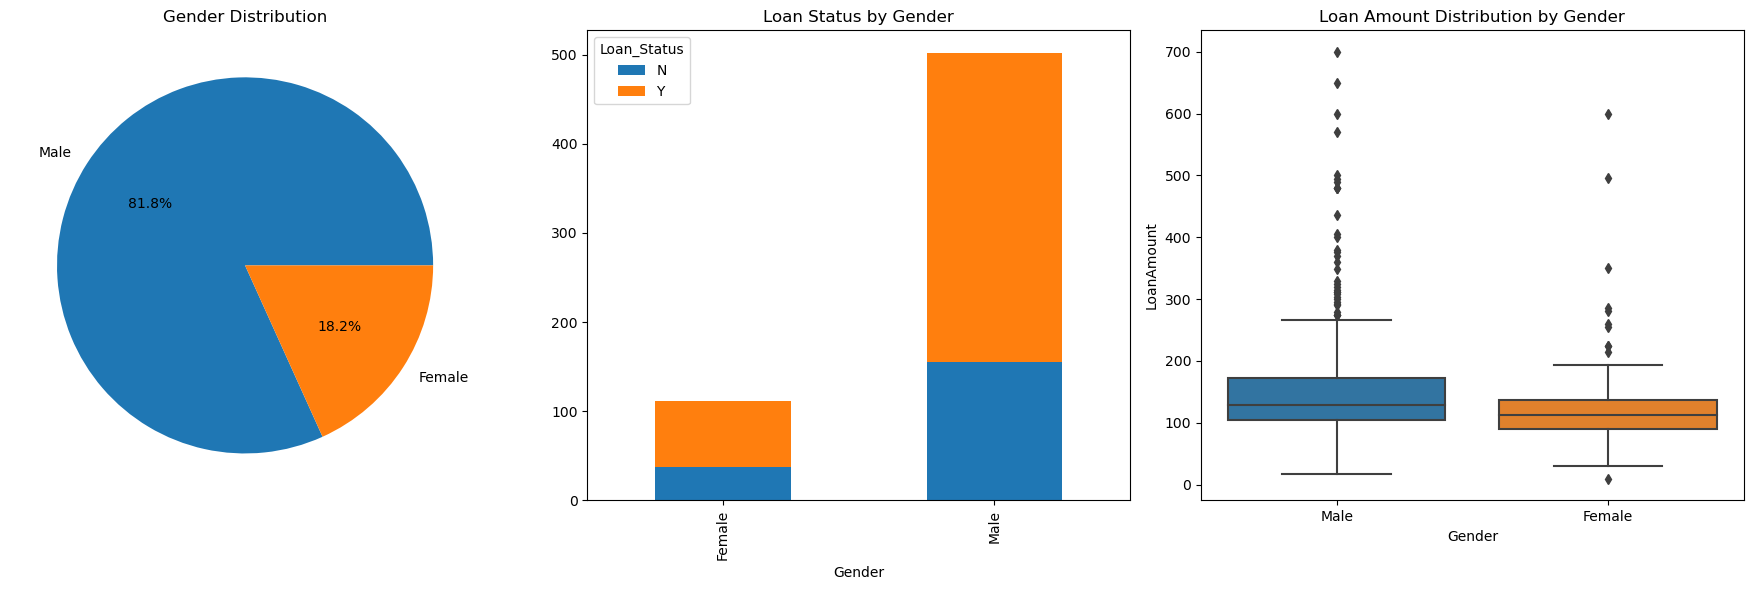

In [14]:
# Calculate the value counts for Gender and Loan_Status
gender_loan_counts = df.groupby('Gender')['Loan_Status'].value_counts().unstack().fillna(0)
gender_counts = df.Gender.value_counts()
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for Gender distribution
axs[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
axs[0].set_title('Gender Distribution')

# Bar plot for Gender and Loan_Status
gender_loan_counts.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Loan Status by Gender')
axs[1].legend(title='Loan_Status')

# Box plot for LoanAmount
sns.boxplot(data=df, x='Gender', y='LoanAmount', ax=axs[2])
axs[2].set_title('Loan Amount Distribution by Gender')

# Adjust the layout
plt.tight_layout()

# Display the charts
plt.show()


Disini kita ingin melihat bagaimana peran gender terhadap loan status dan jumlah loan yang dipinjam:
- Dari 614 data, 81% sejumlah 497 dari data tersebut adalah laki-laki dan hanya 18% atau 117 berupa perempuan. Dapat disimpulkan laki-laki merupakan market yang dominan untuk peminjaman platform.
- Namun jika melihat dari persen peminjaman yang disetujui, ternyata perempuan lebih banyak disetujui sebesar 70% sedangkan laki-laki sebesar 69%.
- Peminjaman laki-laki juga melakukan pengajuan yang lebih besar dibandingkan wanita.

Kesimpulan: dapat disimpulkan bawha target utama dalam loan ini lebih ke arah laki-laki karena market yang sangat besar dan begitu juga pinjaman yang dilakukan lebih besar, dimana bunga yang diperoleh lebih besar dan merunjuk pada profit perusahaan.

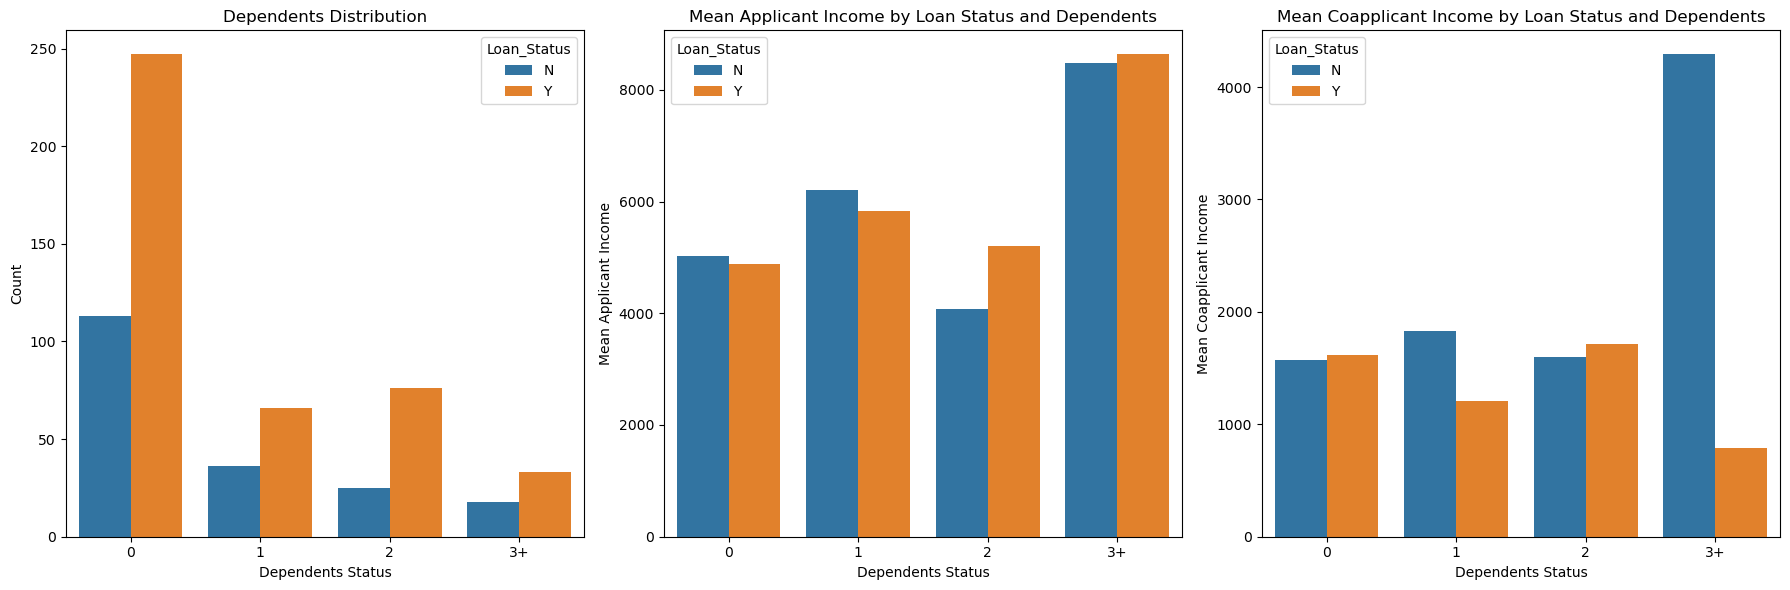

In [15]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Dependents distribution
viz1 = df.groupby('Loan_Status', as_index=False)['Dependents'].value_counts()
sns.barplot(data=viz1, x='Dependents', y='count', hue='Loan_Status', ax=axs[0])
axs[0].set_xlabel('Dependents Status')
axs[0].set_ylabel('Count')
axs[0].set_title('Dependents Distribution')

# Second subplot: Mean Applicant Income by Loan Status and Dependents
viz2 = df.groupby(['Loan_Status','Dependents'], as_index=False)['ApplicantIncome'].mean()
sns.barplot(data=viz2, x='Dependents', y='ApplicantIncome', hue='Loan_Status', ax=axs[1])
axs[1].set_xlabel('Dependents Status')
axs[1].set_ylabel('Mean Applicant Income')
axs[1].set_title('Mean Applicant Income by Loan Status and Dependents')

# Third subplot: Mean Coapplicant Income by Loan Status and Dependents
viz3 = df.groupby(['Loan_Status','Dependents'], as_index=False)['CoapplicantIncome'].mean()
sns.barplot(data=viz3, x='Dependents', y='CoapplicantIncome', hue='Loan_Status', ax=axs[2])
axs[2].set_xlabel('Dependents Status')
axs[2].set_ylabel('Mean Coapplicant Income')
axs[2].set_title('Mean Coapplicant Income by Loan Status and Dependents')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


Disini kita mencari tahu bagaimana income invididu yang mempunyai dependen mempengaruhi loannya disetujui atau tidak.
- Dapat kita lihat bahwa individu yang tidak memiliki dependen yang paling banyak disetujui loannya, diikuti oleh individu dengan 2 dependen
- Jika kita melihat pada income invididu, menariknya tidak semua individu yang tidak mempunyai dependen memiliki income yang lebih tinggi dibandingkan dengan yang mempunyai dependan. 
- Individu yang memiliki income yang tinggi tidak menjamin loannya diterima, bahkan jika digabungkan dengan income coapplicantnya.

Kesimpulan: Individu dengan tidak ada dependen adalah target utama walaupun pendapatan mereka dan ditambah dengan pendapatan coapplicant tidak lebih banyak ketimbang individu yang mempunyai dependen. Individu dengan 2 dependen bagaimanapun juga mempunyai nilai yang lebih tinggi untuk loannya disetejui.

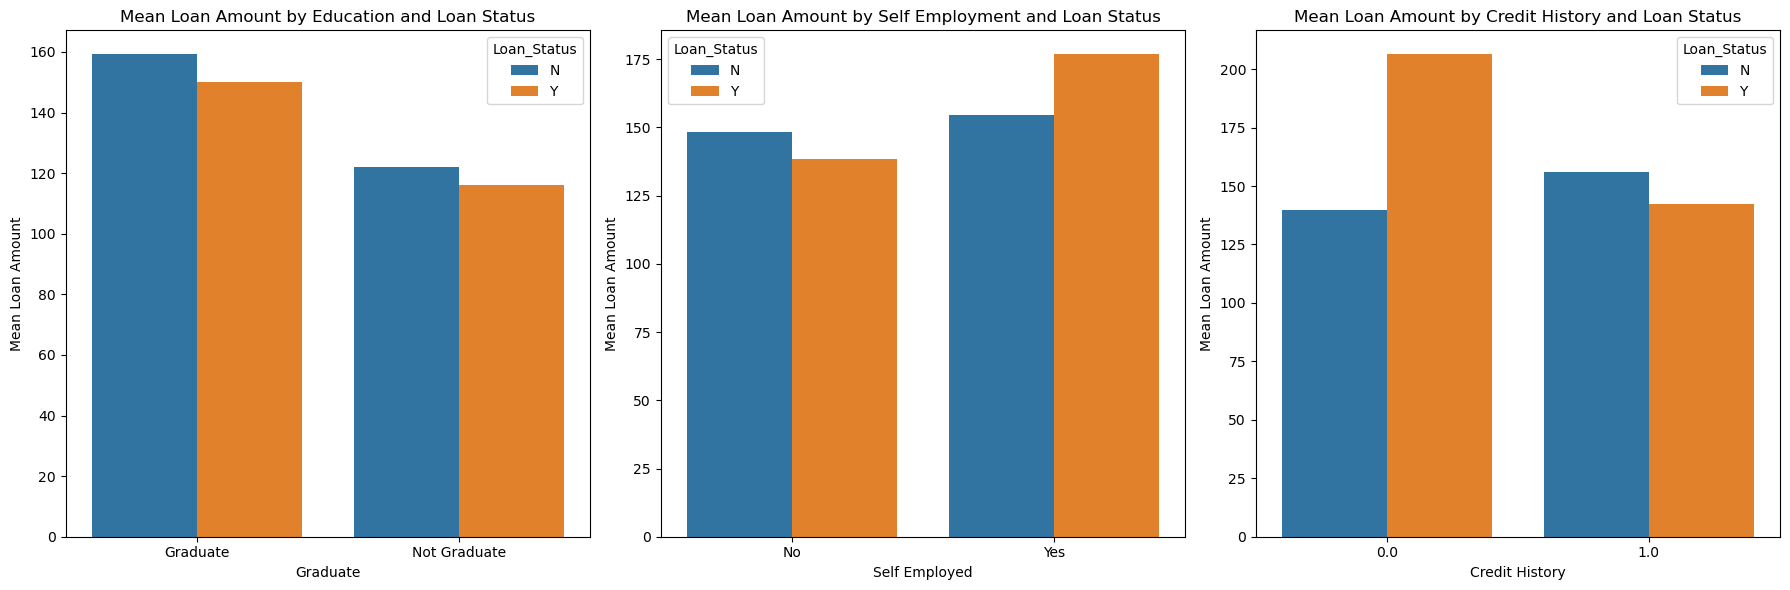

In [16]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Loan Amount by Education and Loan Status
viz1 = df.groupby(['Loan_Status','Education'])[['LoanAmount']].mean().reset_index()
sns.barplot(data=viz1, x='Education', y='LoanAmount', hue='Loan_Status', ax=axs[0])
axs[0].set_xlabel('Graduate')
axs[0].set_ylabel('Mean Loan Amount')
axs[0].set_title('Mean Loan Amount by Education and Loan Status')

# Second subplot: Loan Amount by Self Employment and Loan Status
viz2 = df.groupby(['Loan_Status','Self_Employed'])[['LoanAmount']].mean().reset_index()
sns.barplot(data=viz2, x='Self_Employed', y='LoanAmount', hue='Loan_Status', ax=axs[1])
axs[1].set_xlabel('Self Employed')
axs[1].set_ylabel('Mean Loan Amount')
axs[1].set_title('Mean Loan Amount by Self Employment and Loan Status')

# Third subplot: Loan Amount by Credit History and Loan Status
viz3 = df.groupby(['Loan_Status','Credit_History'])[['LoanAmount']].mean().reset_index()
sns.barplot(data=viz3, x='Credit_History', y='LoanAmount', hue='Loan_Status', ax=axs[2])
axs[2].set_xlabel('Credit History')
axs[2].set_ylabel('Mean Loan Amount')
axs[2].set_title('Mean Loan Amount by Credit History and Loan Status')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


Disini kita melihat seberapa banyak pinjaman yang dilakukan oleh individu terhadap background edukasi, pekerjaan dan credit history mereka:
- Individu yang telah graduasi cenderung meminjam lebih banyak, baik yang disetujui maupun tidak dibandngkan dengan yang tidak graduasi. 
- Begitu pula dengan individu yang merupakan self-employed
- Menariknya disni adalah individu dengan yang tidak adanya credit history merekea cenderung meminjam lebih banyak 30% dibandingkan dengan yang lain.

Kesimpulan: background seperti graduasi, self-employed dan credit history berpengaruh terhadap jumlah peminjaman yang dilakukan. Namun dari segi bisnis fitur seperti self-employed dan credit history cukup menjadikan dilema karena resiko yang lebih besar. Saya katakan resiko lebih besar karena yang kita ketahui self-employed tidak mendapatkan pendapatan yang tetap, dan credit history individu yang belum pernah meminjam kita tidak tahu bagaimana seberapa baik mereka dalam mengembalikan loannya.

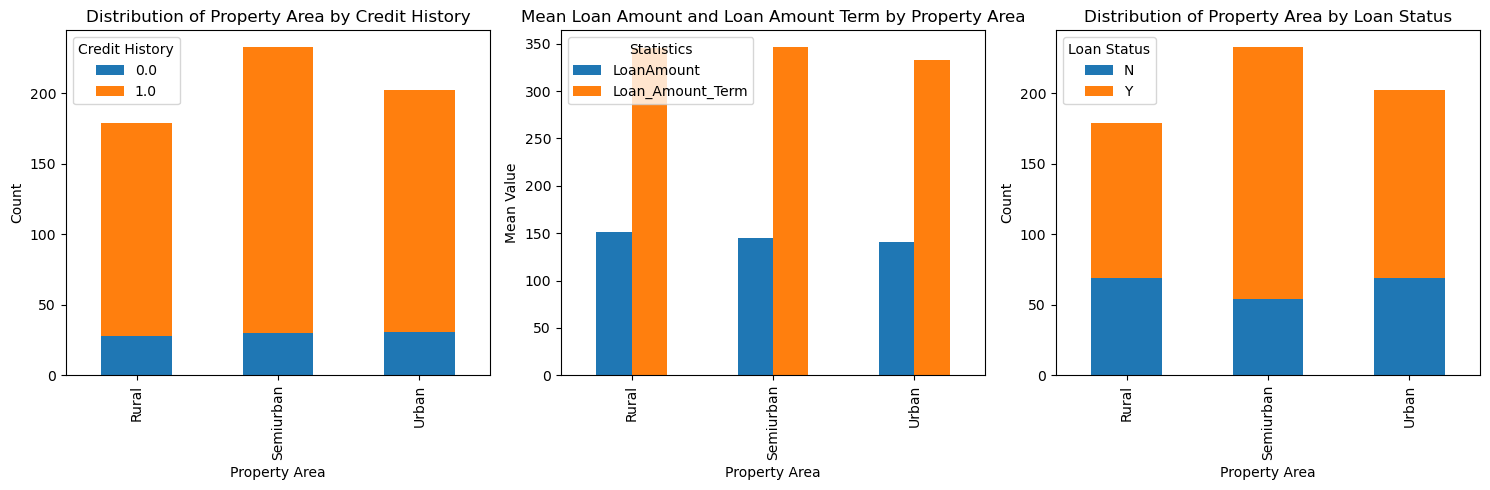

In [17]:
# Grouped bar plot for Credit_History and Property_Area
credit_property_counts = df.groupby('Property_Area')['Credit_History'].value_counts().unstack()

# Bar plot for LoanAmount and Loan_Amount_Term by Property_Area
loan_stats = df.groupby('Property_Area')[['LoanAmount','Loan_Amount_Term']].mean()

# Grouped bar plot for Loan_Status and Property_Area
loan_status_property_counts = df.groupby('Property_Area')['Loan_Status'].value_counts().unstack()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot 1 - Credit_History and Property_Area
credit_property_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Property Area')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Property Area by Credit History')
axes[0].legend(title='Credit History')

# Plot 2 - LoanAmount and Loan_Amount_Term by Property_Area
loan_stats.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Property Area')
axes[1].set_ylabel('Mean Value')
axes[1].set_title('Mean Loan Amount and Loan Amount Term by Property Area')
axes[1].legend(title='Statistics')

# Plot 3 - Loan_Status and Property_Area
loan_status_property_counts.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_xlabel('Property Area')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Property Area by Loan Status')
axes[2].legend(title='Loan Status')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


Disini kita melihat hubungan property area dengan jumlah pinjaman, apakah property area mempengaruhi suatu pinjaman disetujui atau tidak:
- Secara garis besar kita melihat bawha 80% lebih individu sudah pernah melakukan pinjaman sebelumnya. Dan pinjaman terbanyak dilakukan pada individu yang tinggal didaerah semi-urban area. 
- Dalam peminjaman dan batas peminjaman, tidaka da indikasi jika tinggal didaerah perkotaan akan mendapatkan batas peminjaman yang lebih. Dan dapat dilihat orang yang tinggal di daerah rural yang meminjam lebih banyak dan mendapatkan batas pinjaman yang lebih tinggi dari yang lain.
- Karena lebih banyak individu yang tinggal di daerah semi-urban, mungkin faktor itu pula yang dapat mengakibatkan loan yang paling banyak disetujui adalah individu yang tinggal di daerah semi-urban

Kesimpulan: hampir 85% individu dalam data sudah pernah melakukan loan sebelumnya, mendandakan market untuk bisis pinjaman sangatlah besar. Tidak tampak terlihatnya indikasi individu yang tinggal di daerah yang lebih besar bisa mendapatkan pinjaman yang lebih banyak, dan juga pinjaman individu tersebut juga tidak lebih banyak dari mereka yang tinggal didaerah jauh dari kota. Dari segi bisnis, dapat melakukan expansi kedaerah diluar perkotaan untuk membuka cabang yang bisa menjangkau lebih banyak target market

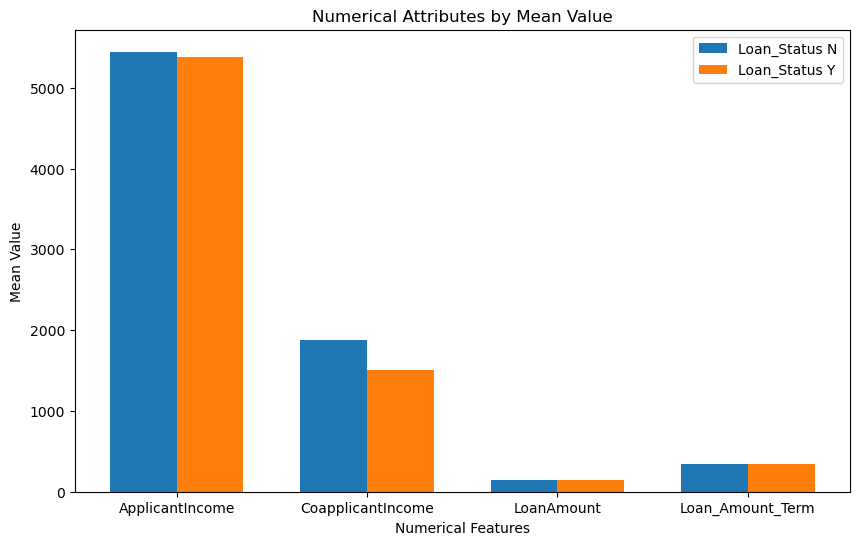

In [18]:
loan_stats = df.groupby('Loan_Status')[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].mean()

# Transpose the dataframe for plotting
loan_stats = loan_stats.T

# Create x-axis positions for the bars
ind = np.arange(len(loan_stats))

# Define width of each bar
width = 0.35

# Create the grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind, loan_stats['N'], width, label='Loan_Status N')
rects2 = ax.bar(ind + width, loan_stats['Y'], width, label='Loan_Status Y')

# Set x-axis labels
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(loan_stats.index)

# Set labels and title
ax.set_xlabel('Numerical Features')
ax.set_ylabel('Mean Value')
ax.set_title('Numerical Attributes by Mean Value')

# Customize legend
ax.legend()

# Show the plot
plt.show()


Disini kita akan melihat apakah pendapatan berpengaruh besar terhadap pinjaman akan diterima atau tidak, batas pinjaman dan juga jumlah pinjaman indidivu.

Dari data diatas, dapat disimpulkan bahwa mempunyai pendapatan yang tinggi tidak berpengaruh signifikan untuk bisa dapat mendapatkan pinjaman. Hal tersebut dapat dilihat dari rata-rata pendapatan sendiri maupun pendapatan cooaplicant. Juga dapat disimpulkan bawha batas rata-rata orang mendapatkan pinjaman berada di angka sekitar 340, dan pada umumnya individu meminjam tidak lebih dari 50% batas peminjamaman.

### Feature Engineering

Setelah melihat hubungan antar features, kita akan melihat feature mana yang merupakan faktor yang paling menentukan terhadap diterima atau tidaknya pengajuan sebuah loan. Kita akan melihat dengan berbagai bantuan machine learning sampai dengan korelasi dan menghitung manual feature yang berpengaruh.

In [19]:
## train test split
X = df.drop('Loan_Status', axis=1)                                                                      
y = df.Loan_Status                                                                                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, stratify=y, random_state=1)    

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(423, 11)
(191, 11)
(423,)
(191,)


In [20]:
X_train_eda = X_train.copy()    ## membuat copy khusus untuk feature engineering

-- Numeric Feature --

Untuk feature engineering outliers dan scaling numeric sangat berpengaruh, oleh sebab itu perlu melihat skew distribusi penyebaran untuk menentukan handling outliers

In [21]:
df[num_col].skew()  ## mengecek skew numerik features

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.743458
Loan_Amount_Term    -2.370033
dtype: float64

Karena skew yang tinggi maka kita dapat menggunakan method IQR dengan fold 3 dan menggunakan MinMaxScaller untuk scaling

In [22]:
num_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']                    ## numeric column variables
wins = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=num_col)     ## Winsorizer function

## handling outliers
X_train_eda = wins.fit_transform(X_train_eda)
X_test = wins.transform(X_test)

In [23]:
scaler = MinMaxScaler()                                                             ## MinMaxScaller function
## transform to X_test
num_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term']  ## numeric column variables
X_train_eda[num_col] = scaler.fit_transform(X_train_eda[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

-- Categorical Feature -- 

Beberapa alasan kenapa saya melakukan ordinal terhadap kolom yang memiliki ordinality
- 'Dependants' : mengikuti dengan EDA diatas dimana dependents 0 menjadikan target utama diikuti oleh 2, 1 dan 3+
- 'Property_Area' : dilihat pada EDA diatas tidak terdapat perubahan yang signifikan pada Loan_Status dengan Property_Area, maka saya memberikan nilai tersendiri

In [24]:
## Handle binary ordinality
binary_col = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']
ordinal = OrdinalEncoder()

## Fit-ransform binary ordinal columns in X_train and X_test
X_train_eda[binary_col] = ordinal.fit_transform(X_train_eda[binary_col])
X_test[binary_col] = ordinal.transform(X_test[binary_col])

## Handle ordinality for 'Dependents' column
ordinal = OrdinalEncoder()
mapping = {'3+': 0, '1': 1, '2': 2, '0': 3} 
## karena terdapat string maka harus diubah manual

## Map and fit transform 'Dependents' column in X_train
X_train_eda['Dependents'] = X_train_eda['Dependents'].map(mapping)
X_train_eda['Dependents'] = ordinal.fit_transform(X_train_eda[['Dependents']])

## Map and transform 'Dependents' column in X_test
X_test['Dependents'] = X_test['Dependents'].map(mapping)
X_test['Dependents'] = ordinal.transform(X_test[['Dependents']])

## One-hot encode 'Property_Area' column
ohe = OneHotEncoder(sparse_output=False)

## One-hot encode 'Property_Area' column in X_train
encoded_train = ohe.fit_transform(X_train_eda[['Property_Area']])
encoded_train = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out(['Property_Area']))
X_train_eda = pd.concat([X_train_eda.reset_index(), encoded_train], axis=1)
X_train_eda.drop(['Property_Area', 'index'], axis=1, inplace=True)

## One-hot encode 'Property_Area' column in X_test
encoded_test = ohe.transform(X_test[['Property_Area']])
encoded_test = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out(['Property_Area']))
X_test = pd.concat([X_test.reset_index(), encoded_test], axis=1)
X_test.drop(['Property_Area', 'index'], axis=1, inplace=True)

Sekarang semua features sudah dalam bilangan numerik yang dimana dapat kita lakukan komputerisasi

In [25]:
# Combine X_train_eda with y_train
combined= pd.concat([X_train_eda, y_train.reset_index(drop=True)], axis=1)
combined.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,1.0,0.0,3.0,0.0,0.0,0.387179,0.411448,0.936306,0.74359,1.0,1.0,0.0,0.0,N
1,1.0,1.0,3.0,1.0,0.0,0.155010,0.261841,0.522293,0.74359,0.0,0.0,0.0,1.0,N
2,1.0,0.0,3.0,0.0,0.0,0.642282,0.000000,0.541401,0.74359,1.0,1.0,0.0,0.0,Y
3,1.0,1.0,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.74359,0.0,1.0,0.0,0.0,N
4,0.0,1.0,3.0,0.0,0.0,0.284806,0.275084,0.296178,0.74359,1.0,0.0,0.0,1.0,N


### Feature Selection

In [26]:
## Using phik matrix
combined.phik_matrix()['Loan_Status'].sort_values(ascending=False)

interval columns not set, guessing: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']


Loan_Status                1.000000
Credit_History             0.734243
Property_Area_Semiurban    0.269691
Property_Area_Rural        0.173561
Married                    0.154687
CoapplicantIncome          0.129550
Loan_Amount_Term           0.123603
Education                  0.100083
Property_Area_Urban        0.063012
Dependents                 0.045747
Gender                     0.000000
Self_Employed              0.000000
ApplicantIncome            0.000000
LoanAmount                 0.000000
Name: Loan_Status, dtype: float64

In [27]:
mutual_info = mutual_info_classif(X_train_eda, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_eda.columns
mutual_info.sort_values(ascending=False)
## mutual_info_classification result

Credit_History             0.149582
Loan_Amount_Term           0.029690
Property_Area_Semiurban    0.025277
Married                    0.020371
Dependents                 0.017023
LoanAmount                 0.014584
Education                  0.013977
ApplicantIncome            0.009417
CoapplicantIncome          0.008581
Self_Employed              0.002415
Property_Area_Rural        0.001029
Gender                     0.000000
Property_Area_Urban        0.000000
dtype: float64

In [28]:
lr = LogisticRegression(max_iter=100000)
rfe = RFE(estimator=lr, n_features_to_select=5, step=1)
rfe.fit(X_train_eda, y_train)
X_train_sub = rfe.transform(X_train_eda)
result = pd.DataFrame(X_train_sub,columns = rfe.get_feature_names_out())
result.head()
## recursive feature elimination result

,Married,Education,LoanAmount,Credit_History,Property_Area_Semiurban
0,0.0,0.0,0.936306,1.0,0.0
1,1.0,1.0,0.522293,0.0,0.0
2,0.0,0.0,0.541401,1.0,0.0
3,1.0,0.0,1.000000,0.0,0.0
4,1.0,0.0,0.296178,1.0,0.0


In [29]:
combined.Loan_Status.replace({
    'Y' : 1,
    'N' : 0
}, inplace=True)

combined.corr()['Loan_Status'].sort_values(ascending=False)

Loan_Status                1.000000
Credit_History             0.533627
Property_Area_Semiurban    0.185583
Married                    0.115479
Dependents                 0.023704
Gender                     0.021835
CoapplicantIncome          0.018674
Self_Employed             -0.018669
ApplicantIncome           -0.023878
Loan_Amount_Term          -0.038134
LoanAmount                -0.040464
Property_Area_Urban       -0.068442
Education                 -0.086484
Property_Area_Rural       -0.126715
Name: Loan_Status, dtype: float64

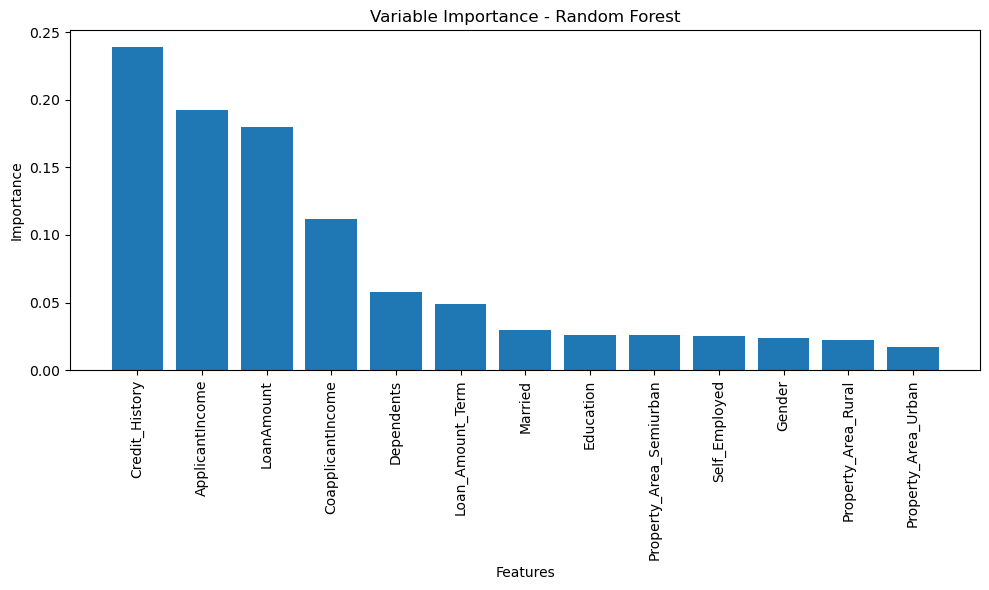

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train_eda, y_train)

## get the feature importances
importances = rf.feature_importances_

## get the feature names
feature_names = X_train_eda.columns

## sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

## plot 
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Variable Importance - Random Forest')
plt.tight_layout()
plt.show()


Berdasarkan dari 5 features selection tools yang digunakan, dapat disimpulkan bawha yang berpengaruh paling besar terhadap diterima tidaknya sebuah pinjaman adalah
1. Credit_History : dimana mempunyai kredit history
2. LoanAmount : dimana lebih mudah disetujui jika loan amount dibawah rata-rata yaitu 149
3. ApplicantIncome : dimana lebih mudah disetujui jika applicant income diatas rata-rata yaitu 5446
4. Dependents : dimana lebih mudah disetujui jika jika tidak ada dependents
5. Property_Area : dimana lebih mudah disetujui jika tinggal selain didaerah Rural

### Conlcusion

- Tingginya income seorang applicant dan coapplicant jika ada, tidak menjadikan faktor utama untuk mendapatkan pinjaman. Namun diketahui bahwa minimum angka income untuk seorang dapat mendapatkan pinjaman adalah 5446
- Credit history adalah faktor yang paling signifikan terhadap dapatnya pinjaman. Mungkin disebabkan oleh mengetahui bagaimana karakteristik individu tersebut terhadap pinjaman-pinjaman sebelumnya.
- Loan amount diatas rata-rata 149 kemungkinan besar akan dilakukan penolakan, hal ini dapat terlihat pada individu yang tinggal didaerah Rural area dimana melakukan peminjaman diatas rata-rata
- Gender tidak berpengaruh besar terdahap pinjaman, tetapi Married, Self_Employed, Education berpengaruh sedikit terhadap penerimaan pinjaman karena dimana individu yang Married, merupakan Self_employed dan Graduate cenderung meminjam diatas rata-rata loan amount.
- Dependents dengan 0 dan 2 sebagaimana mempunyai nilai pinjaman yang lebih kecil ketimbang dari yang lainnya.

Rata-rata income dan pinjaman tidak berbeda jauh antara Loan_Status Yes dan No secara kasat mata, namun nilai rata-rata itu mementukan mana yang lolos atau tidak. Implementasi dalam dunia bisnis, tentunya yang dapat kita ukur adalah secara numerik, dan perbedaan yang tidak signifikan tersebut tentunya akan sangat berpengaruh terhadap profit perusahaan jika total customer nya yang besar.